In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import numpy as np
import torch
import torch.nn as nn

import sys
sys.path.append('/root/mediazen/speech2blendshape/')

from src.datasets.new_dataset import FaceDataset, GGongGGongDataset
from src.datasets.new_datamodule import FaceDataModule, GGongGGongDataModule
from src.models.full_deepspeech import DeepSpeech
from src.models.pl_model import GANCNNGenPatchDisc, GANCNNGenPatchDisc2
from src.utils import plot_spectrogram, plot_result

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [3]:
base_dir = '/shared/air/shared/youngkim/mediazen'
device = 'cuda:1'
deepspeech_model_path = os.path.join(base_dir, 'pretrained/librispeech_pretrained_v2.pth')

In [4]:
dm = GGongGGongDataModule(
    base_dir=base_dir,
    batch_size=2,
    num_workers=32,
    seed=1234,
    blendshape_columns=['JawForward','JawOpen','MouthClose','MouthFunnel','MouthPucker','MouthDimpleLeft','MouthDimpleRight','MouthStretchLeft','MouthStretchRight','MouthRollLower','MouthRollUpper','MouthShrugLower','MouthShrugUpper','MouthPressLeft','MouthPressRight','CheekPuff'],
    speakers=['jiha']
)

In [5]:
dm.prepare_data()
dm.setup()

for x, x_length, y, y_length in dm.train_dataloader():
    break

In [6]:
x, x_length = x.to(device), x_length.to(device)
y, y_length = y.to(device), y_length.to(device)
x.shape, x_length, y.shape, y_length

(torch.Size([2, 11682, 161]),
 tensor([4691, 3829], device='cuda:1', dtype=torch.int32),
 torch.Size([2, 7012, 16]),
 tensor([2818, 2303], device='cuda:1', dtype=torch.int32))

In [7]:
pl_model = GANCNNGenPatchDisc2(None, 0, deepspeech_model_path, 16)
pl_model.to(device)
None

In [8]:
enc_out, rnn_out, x_length = pl_model.encoder(x, x_length, return_both=True)
enc_out = enc_out.permute(1, 2, 0) # B, C, T
speech_features = pl_model.interpolate_features(enc_out, x_length, y_length)
out = pl_model.net_G(speech_features)
masked_out, chopped_y = pl_model.masking_preds(out, y, y_length)

/root/mediazen/speech2blendshape/src/models/full_deepspeech.py:251: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  seq_len = ((seq_len + 2 * m.padding[1] - m.dilation[1] * (m.kernel_size[1] - 1) - 1) // m.stride[1] + 1)


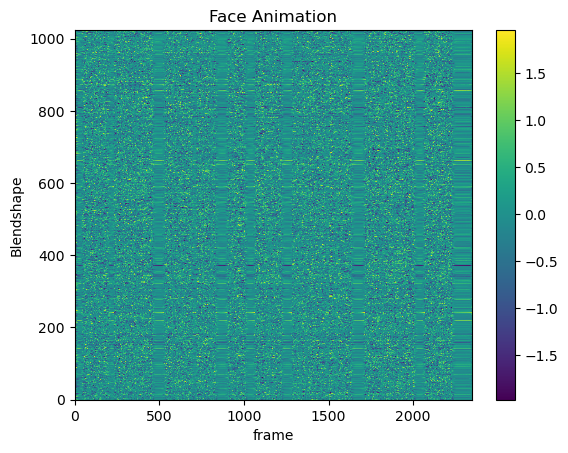

In [12]:
plot_result(rnn_out[:,0,:].cpu().detach().permute(1, 0))

In [13]:
rnn_out.shape # T, B, C

torch.Size([2346, 2, 1024])

In [14]:
rnn_out = rnn_out.permute(1, 2, 0) # B, C, T
rnn_out_intp = pl_model.interpolate_features(rnn_out, x_length, y_length)
rnn_out_intp.shape
# B, 1024, T -> B, C, T, 16

torch.Size([2, 1024, 2818])

In [15]:
masked_out.shape, chopped_y.shape

(torch.Size([2, 1, 2818, 16]), torch.Size([2, 1, 2818, 16]))

In [74]:
# conv = nn.Sequential(
#     nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(8),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(16),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(32),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(32),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(32),
#     nn.ReLU(inplace=True),
#     nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1)),
#     nn.BatchNorm2d(64),
#     nn.ReLU(inplace=True)
# )

# conv.to(device)
# None

In [75]:
# a = conv(rnn_out_intp.unsqueeze(1))
# a.shape

torch.Size([1, 64, 16, 2763])

In [24]:
class MaskConv(nn.Module):
    def __init__(self, seq_module):
        """
        Adds padding to the output of the module based on the given lengths. This is to ensure that the
        results of the model do not change when batch sizes change during inference.
        Input needs to be in the shape of (BxCxDxT)
        :param seq_module: The sequential module containing the conv stack.
        """
        super(MaskConv, self).__init__()
        self.seq_module = seq_module

    def forward(self, x, lengths):
        """
        :param x: The input of size BxCxDxT
        :param lengths: The actual length of each sequence in the batch
        :return: Masked output from the module
        """
        for module in self.seq_module:
            x = module(x)
            mask = torch.BoolTensor(x.size()).fill_(0)
            if x.is_cuda:
                mask = mask.to(x.device)
            for i, length in enumerate(lengths):
                length = length.item()
                if (mask[i].size(2) - length) > 0:
                    mask[i].narrow(2, length, mask[i].size(2) - length).fill_(1)
            x = x.masked_fill(mask, 0)
        return x, lengths

class BasicBlock(nn.Module):

    expansion = 1

    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=stride,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=1,
                          stride=stride,
                          bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.act = nn.GELU()

    def forward(self, x):
        out = self.conv(x) + self.shortcut(x)
        out = self.act(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, block_nums) -> None:
        super().__init__()

        self.stem = MaskConv(nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=7,
                      stride=(4, 1),
                      padding=3,
                      bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
        ))

        self.in_channels = 32
        self.stage1 = self._make_stage(32, block, block_nums[0], (2, 1))
        self.stage2 = self._make_stage(32, block, block_nums[1], (2, 1))
        self.stage3 = self._make_stage(64, block, block_nums[2], (2, 1))
        self.stage4 = self._make_stage(64, block, block_nums[3], (2, 1))

    def _make_stage(self, out_channels, block, block_num, stride):
        stage = []
        for i in range(block_num):
            if i >= 1:
                stride = 1
            stage.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return MaskConv(nn.Sequential(*stage))

    def forward(self, x, x_length):
        out, x_length = self.stem(x, x_length)
        out, x_length = self.stage1(out, x_length)
        out, x_length = self.stage2(out, x_length)
        out, x_length = self.stage3(out, x_length)
        out, x_length = self.stage4(out, x_length)
        return out

def resnet34():
    return ResNet(BasicBlock, [3, 3, 9, 3])

conv = resnet34()
conv.to(device)
# rnn_out_intp B, 1, 1024, T
feature_D = conv(rnn_out_intp.unsqueeze(1), y_length)
feature_D = feature_D.permute(0, 1, 3, 2).contiguous()
feature_D.shape

torch.Size([2, 64, 2818, 16])

In [27]:
chopped_y.shape

torch.Size([2, 1, 2818, 16])